In [1]:
# pandas module
import geopandas as gpd
import pandas as pd

# Shapely for creating geometries
from shapely.geometry import Point
from shapely.ops import triangulate

# osmnx for fetching OSM data
#networkx for working with graphs
import osmnx as ox
import networkx as nx
ox.config(use_cache=True)

# MPL for plotting
# mpl_toolkits for better colorbars
# contextily for adding map to mpl plots
# mplleaflet for interactive plots
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx
import mplleaflet
%matplotlib inline

# Path
import os.path
from pathlib import Path

# Подготовка данных
Загрузим данные о всех типах квартир и объединим в один датасет.

In [2]:
root = os.path.dirname(os.path.abspath(''))
docs = os.path.join(root, 'docs')
data = os.path.join(root, 'data')
gpkgs = [path for path in Path(data).rglob('*.gpkg')]

In [3]:
df = gpd.GeoDataFrame()
for path in gpkgs:
    type_df = gpd.read_file(path)
    df = df.append(type_df, ignore_index=True) 
    print('{:8s} added {:5d} to the {:5d} of total datapoints'.format(path.stem, len(type_df), len(df)))
df.crs = 'epsg:4326'

data_clean added 42770 to the 42770 of total datapoints
metro    added    72 to the 42842 of total datapoints
spb      added    19 to the 42861 of total datapoints
lotrooms added  5470 to the 48331 of total datapoints
oneroom  added  5059 to the 53390 of total datapoints
studio   added  6092 to the 59482 of total datapoints
tworooms added  6588 to the 66070 of total datapoints


In [4]:
df['added_time'] = pd.to_datetime(df['added_time'])
df['parsed_at'] = pd.to_datetime(df['parsed_at'])

In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66070 entries, 0 to 66069
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                66051 non-null  object        
 1   price                65998 non-null  float64       
 2   rooms                64541 non-null  float64       
 3   square               65939 non-null  float64       
 4   living_square        50836 non-null  float64       
 5   kitchen_square       45056 non-null  float64       
 6   metro                54509 non-null  object        
 7   floor                65939 non-null  float64       
 8   max_floor            65939 non-null  float64       
 9   year_built           16356 non-null  float64       
 10  house_type           65939 non-null  object        
 11  not_built            20042 non-null  object        
 12  seller_name          65957 non-null  object        
 13  link                 65

Дропнем колонку с ```seller_rating```, поскольку они полностью состоят из *nan*. Затем уберем из датасета записи, в которых нет данных о количестве комнат и, на всякий случай, дропнем дубликаты. 

In [6]:
df = df.drop(['seller_rating'], 1)
df = df.drop_duplicates(['price', 'title', 'address', 'seller_name', 'metro'])
df = df[(df.rooms.notna()) & (df.geometry.notna())]

Есть такие *плохие люди*, которые не указывают адрес дома. Поскольку подобных объявлений достаточно много, они будут мешать статистике Центрального района (геокодинг точки в "Санкт-Петербург" показывает на Дворцовую). 

In [7]:
df[df.address == 'Санкт-Петербург'].groupby('seller_name').size().sort_values(ascending=False)

seller_name
ПетроИнвестГрупп             180
ООО "Вавилон Сити"            72
Единый центр недвижимости     50
Петроградская                 47
ООО Единый центр квартир      19
Новостройки                   16
Архитектура Недвижимости      12
Sunday Estate                  2
Авангард Недвижимость          2
Айдын                          1
Александр                      1
Валентина                      1
Виктор                         1
Виктория                       1
Марина                         1
частное лицо                   1
Ольга                          1
частное                        1
Петербургская квартира         1
Пользователь                   1
РиК                            1
Собственник                    1
Татьяна                        1
Триумф                         1
Физическое лицо                1
Эдуард-Собственник             1
асми                           1
людмила                        1
ПРОДАВЕЦ                       1
dtype: int64

Эти объявления можно либо дропнуть, либо закодировать их по ближайшему метро. Поскольку их таких почти 4% от всего датасета, я решил выбрать второй путь.

In [8]:
idx = df[df.address == 'Санкт-Петербург'].index
df['address'] = df.apply(lambda r: 'Станция метро ' + r['metro'] + ', Санкт-Петербург' if r['address'] == 'Санкт-Петербург' else r['address'], axis=1)

Перед геокодингом перевернем координаты

In [10]:
def fix_coords(p, how='lonlat'):
    if how == 'lonlat':
        if p.x > 45:
            p = Point(p.y, p.x)
    elif how == 'latlon':
        if p.y > 45:
            p = Point(p.y, p.x)
    return p

df['geometry'] = df.geometry.map(fix_coords, {'how':'lonlat'})

In [12]:
from secret import API_KEY
points = gpd.tools.geocode(df.loc[idx].address, provider='Yandex', api_key=API_KEY, timeout=10)
points.head()

,geometry,address
43050,POINT (30.25190 59.84195),"метро Проспект Ветеранов, 1 линия, Санкт-Петер..."
43051,POINT (30.43920 59.93243),"метро Ладожская, 4 линия, Санкт-Петербург, Россия"
43052,POINT (30.29972 59.90721),"метро Балтийская, 1 линия, Санкт-Петербург, Ро..."
43053,POINT (30.42377 59.89664),"метро Елизаровская, 3 линия, Санкт-Петербург, ..."
43054,POINT (30.29666 60.00252),"метро Пионерская, 2 линия, Санкт-Петербург, Ро..."


In [13]:
df.loc[points.index, 'geometry'] = points.geometry

Преобразуем latitude/longitude в longitude/latitude, поменяв местами координаты

In [14]:
df['longitude'] = df.geometry.map(lambda p: p.x)
df['latitude'] = df.geometry.map(lambda p: p.y)

# Получим данные о районах с OpenStreetMap

In [22]:
districts = [
    'Адмиралтейский',
    'Василеостровский',
    'Выборгский',
    'Калининский',
    'Кировский',
    'Красносельский',
    'Красногвардейский',
    'Колпинский',
    'Кронштадтский',
    'Курортный',
    'Петродворцовый',
    'Пушкинский',
    'Московский',
    'Невский',
    'Петроградский',
    'Фрунзенский',
    'Центральный',
    'Приморский'
]
places = ['{} район, Санкт-Петербург, Россия'.format(d) for d in districts]
spb = ox.gdf_from_places(places)

In [23]:
spb = spb.drop(spb.columns[spb.columns.str.contains('bbox')], 1)
spb['place_name'] = districts
spb = spb.rename(columns={'place_name':'district'})

In [24]:
spb = spb.to_crs(df.crs)

Также отдельно выделим Крестовский остров. По первым запросам выдаются точки, поэтому для выберем четвертый запрос. В нем то, что нам нужно.

In [25]:
krest = ox.gdf_from_place('Крестовский остров, Санкт-Петербург', which_result=3)

krest['district'] = ['Крестовский остров']
krest = krest.loc[:, ['geometry', 'district']]
krest = krest.to_crs('epsg:4326')

Соответственно, из Петроградского района его нужно "вычесть".

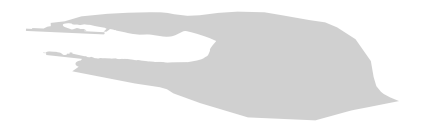

In [26]:
petro = gpd.overlay(spb[spb.district == 'Петроградский'], krest, how='difference')
petro.plot()
plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
spb.loc[14, 'geometry'] = petro.geometry.iloc[0]
spb = spb.append(krest, ignore_index=True)

Посмотрим на результат

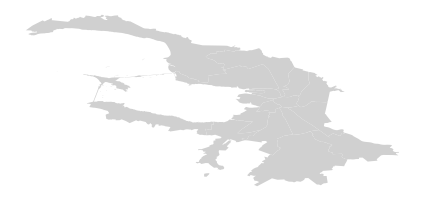

In [28]:
spb.plot(figsize=(6, 6))
plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
spb

,geometry,district
0,"POLYGON ((30.25023 59.90129, 30.25112 59.90103...",Адмиралтейский
1,"POLYGON ((30.17787 59.94437, 30.17790 59.94403...",Василеостровский
2,"POLYGON ((30.07078 60.09625, 30.07421 60.09397...",Выборгский
3,"POLYGON ((30.34398 59.97727, 30.34399 59.97721...",Калининский
4,"POLYGON ((30.16148 59.87425, 30.16158 59.87412...",Кировский
5,"MULTIPOLYGON (((30.03496 59.71785, 30.04040 59...",Красносельский
6,"POLYGON ((30.39428 59.92902, 30.39591 59.92574...",Красногвардейский
7,"POLYGON ((30.43944 59.82803, 30.44391 59.82827...",Колпинский
8,"MULTIPOLYGON (((29.53948 60.04409, 29.53974 60...",Кронштадтский
9,"POLYGON ((29.42981 60.18954, 29.44772 60.18898...",Курортный


Сделаем spatial join между районами Петербурга и датасетом

In [30]:
df = gpd.sjoin(df, spb)
df = df.drop(['index_right'], 1)
df = df.drop_duplicates(['title', 'price', 'square', 'geometry'], keep='last')

# Сохраним чистый датасет

In [31]:
df.to_file(os.path.join(data, 'data_clean.gpkg'), driver='GPKG')
spb.to_file(os.path.join(data, 'spb.gpkg'), driver='GPKG')